## News :D



In [2]:
%load_ext autoreload
%autoreload 2

import requests
import re 
import itertools
from bs4 import BeautifulSoup # Imports bs4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import articles
import sitemaps
import test_functions

# Data

### Data formats

CNN has links by month

NYT has links by day

BI has links by month

TH has links by day

NYP has links by day

DM has links by day

Fox has links by page num

### Thoughts on how to organize the data 

we use a pandas dataframe organized like this

| Dates | CNN | NYT | BI | TH | NYP | DM | FOX |
| ----------- | ------------------------------------------ | ------- | ------- | ------- | ------- | ------- | ------- |
| 2014-01-01  | list of tuples with article link & title   | ... | ... | ... | ... | ... | ... |
| 2014-01-02  | ... | ... | ... | ... | ... | ... | ... |
| 2014-01-03  | ... | ... | ... | ... | ... | ... | ... |
| 2014-01-04  | ... | ... | ... | ... | ... | ... | ... |
| ...         | ... | ... | ... | ... | ... | ... | ... |
| 2024-12-31  | ... | ... | ... | ... | ... | ... | ... |

### Code to get data
CNN:
```html
<li>
    <span class="date">2024-01-31</span>
    <span class="sitemap-link">
        <a href="https://www.cnn.com/tech/live-news/meta-x-discord-tiktok-snap-chiefs-testimony-senate/index.html">
            Mark Zuckerberg apologizes to families over social media harms in contentious Senate hearing
        </a>
    </span>
</li>
```

NYT:
```html
<li>
    <a href="https://www.nytimes.com/2023/12/31/business/dealbook/pga-tour-saudi-deal-deadline.html">
        PGA Tour and Saudi-Backed LIV Extend Deadline to Finalize Deal
    </a>
</li>
```

BI:
```html
<p>
    <a href="https://www.businessinsider.com/feud-capote-vs-swans-ann-woodward-suicide-death-real-story-2024-1">
        The real story behind the suicide of American socialite Ann Woodward in &#39;Feud: Capote vs. The Swans&#39;
    </a>
    <br>2024-02-01T03:31:01.68Z
</p>
```

NYP:
```html
<h3 class="story__headline headline headline--archive">
    <a href="https://nypost.com/2024/01/01/sports/og-anunoby-trending-toward-the-perfect-piece-for-knicks/" rel="" target="_self">
		Knicks&#039; big trade acquisition already looks like the &#039;perfect fit&#039; 												
    </a>
</h3>
```

DM:
```html
<a href="/wires/ap/article-12917573/Christian-McCaffrey-miss-49ers-regular-season-finale-return-playoffs.html" title="">
    Christian McCaffrey will miss the 49ers regular-season finale but should return for playoffs
</a>
```

FOX:
```html
<loc>
    https://www.foxnews.com/opinion/why-the-department-of-education-is-going-to-rip
</loc>
<lastmod>
    2025-03-12T05:00:54-04:00
</lastmod>
```

In [3]:
start_year = 2020
end_year = 2020
start_month = 1
end_month = 12

[dataframe, example_dataframe] = articles.get_data(start_year, end_year, start_month, end_month)

/home/grant/Documents/HeadlineCorrelation/articles.py:269: XMLParsedAsHTMLWarning: It looks like you're using an HTML parser to parse an XML document.

Assuming this really is an XML document, what you're doing might work, but you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the Python package 'lxml' installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

If you want or need to use an HTML parser on this document, you can make this warning go away by filtering it. To do that, run this code before calling the BeautifulSoup constructor:

    from bs4 import XMLParsedAsHTMLWarning
    import warnings

    warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

  urls = BeautifulSoup(pulled_data.text, "lxml").find_all("url")


['https://www.theepochtimes.com/us/trump-administration-to-decriminalize-accidental-killing-of-birds-3223129', 'https://www.theepochtimes.com/us/flynn-slams-former-lawyers-for-misleading-him-on-their-conflict-of-interest-3222616', 'https://www.theepochtimes.com/us/ruth-bader-ginsburg-criticizes-washington-dysfunction-amid-impeachment-trial-3223389', 'https://www.theepochtimes.com/us/trump-creates-new-position-dedicated-to-fighting-human-trafficking-3223105', 'https://www.theepochtimes.com/us/california-wedding-industry-turned-on-top-of-its-head-by-freelancing-law-3222935', 'https://www.theepochtimes.com/us/states-sue-to-compel-us-to-add-equal-rights-amendment-to-constitution-3221013', 'https://www.theepochtimes.com/us/helicopter-company-in-kobe-bryant-crash-not-certified-to-fly-in-poor-visibility-reports-3222814', 'https://www.theepochtimes.com/us/pompeo-says-huawei-is-a-risk-but-u-s-will-resolve-differences-with-uk-3222621', 'https://www.theepochtimes.com/us/ag-barr-appoints-top-advis

In [ ]:
[words, title_counts] = test_functions.most_common(start_year,end_year,start_month,end_month,'Trump',dataframe)

for source in words:
    del_words = []

    for i in words[source]:
        words[source][i] = (words[source][i] / title_counts[source]) * 100

    for i in words[source]:
        if words[source][i] <= 1:
            del_words.append(i)
    for i in del_words:
        del words[source][i]


dels = []
for i in words['CNN']:
    if i not in words['NYT']:
        dels.append(i)
for i in dels:
    del words['CNN'][i]


dels = []
for i in words['NYT']:
    if i not in words['CNN']:
        dels.append(i)
for i in dels:
    del words['NYT'][i]


for word in words['CNN']:
    print(word)
    print(f"CNN: {words['CNN'][word]}")
    print(f"NYT: {words['NYT'][word]}")
    print("")


Bloomberg
CNN: 1.1764705882352942
NYT: 1.675977653631285

Biden
CNN: 1.1764705882352942
NYT: 1.9553072625698324

John
CNN: 1.411764705882353
NYT: 1.675977653631285

Davos
CNN: 1.647058823529412
NYT: 1.9553072625698324

but
CNN: 1.647058823529412
NYT: 1.675977653631285

China
CNN: 1.647058823529412
NYT: 2.793296089385475

Parnas
CNN: 1.647058823529412
NYT: 1.1173184357541899

Why
CNN: 1.8823529411764703
NYT: 1.9553072625698324

New
CNN: 2.1176470588235294
NYT: 2.2346368715083798

Middle
CNN: 2.3529411764705883
NYT: 1.675977653631285

East
CNN: 2.3529411764705883
NYT: 1.675977653631285

What
CNN: 2.588235294117647
NYT: 4.748603351955307

Iranian
CNN: 2.823529411764706
NYT: 1.3966480446927374

by
CNN: 3.058823529411765
NYT: 2.5139664804469275

Impeachment
CNN: 3.058823529411765
NYT: 13.128491620111731

Ukraine
CNN: 3.5294117647058822
NYT: 3.35195530726257

How
CNN: 4.0
NYT: 2.793296089385475

Bolton
CNN: 4.0
NYT: 2.793296089385475

as
CNN: 4.235294117647059
NYT: 5.307262569832402

US
CNN:

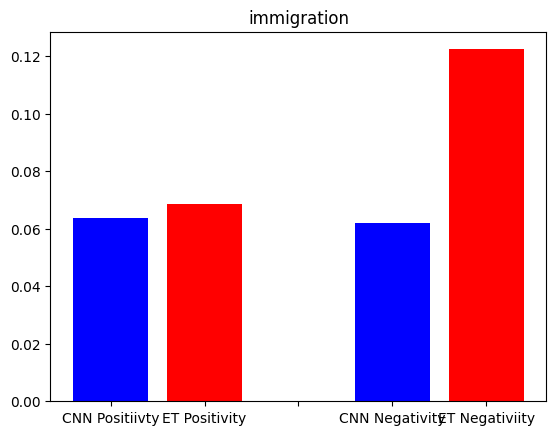

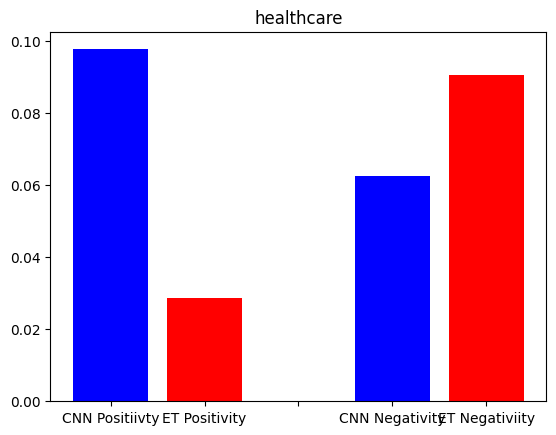

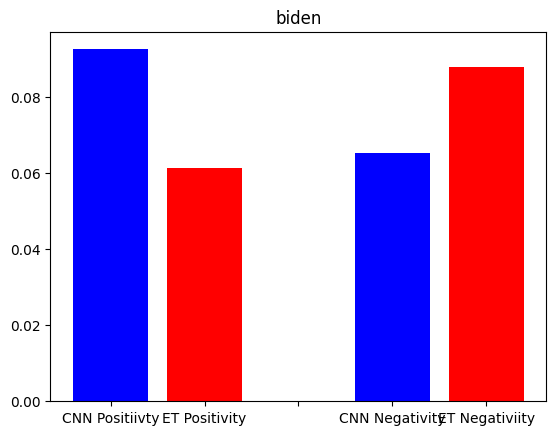

In [6]:
[issue1_values, issue1_title_counts] = test_functions.word_sentiment(start_year,end_year,start_month,end_month,'immigration',dataframe)
[issue2_values, issue2_title_counts] = test_functions.word_sentiment(start_year,end_year,start_month,end_month,'healthcare',dataframe)
[issue3_values, issue3_title_counts] = test_functions.word_sentiment(start_year,end_year,start_month,end_month,'biden',dataframe)



colors = ['blue','red','black','blue','red']
x = np.array(["CNN Positiivty", "ET Positivity", "", "CNN Negativity", "ET Negativiity"])
y = np.array([issue1_values['CNN']['pos'], issue1_values['ET']['pos'], 0, issue1_values['CNN']['neg'], issue1_values['ET']['neg']])

plt.bar(x,y,color=colors)
plt.title('immigration')
plt.show()


colors = ['blue','red','black','blue','red']
x = np.array(["CNN Positiivty", "ET Positivity", "", "CNN Negativity", "ET Negativiity"])
y = np.array([issue2_values['CNN']['pos'], issue2_values['ET']['pos'], 0, issue2_values['CNN']['neg'], issue2_values['ET']['neg']])

plt.bar(x,y,color=colors)
plt.title('healthcare')
plt.show()


colors = ['blue','red','black','blue','red']
x = np.array(["CNN Positiivty", "ET Positivity", "", "CNN Negativity", "ET Negativiity"])
y = np.array([issue3_values['CNN']['pos'], issue3_values['ET']['pos'], 0, issue3_values['CNN']['neg'], issue3_values['ET']['neg']])

plt.bar(x,y,color=colors)
plt.title('biden')
plt.show()